In [209]:
from sklearn.datasets import load_digits
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [73]:
digits = load_digits()
X = digits.data
Y = digits.target

In [99]:
Y[0:12]

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1])

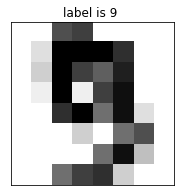

In [119]:
def plot_number_by_data(img_data, label, label_two = ""):
    plt.figure(1, figsize=(3, 3))
    plt.imshow(img_data.reshape((8,8)), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.xticks([])
    plt.yticks([])
    plt.title(f"label is {label} {label_two}")
    plt.show()

def plot_number_by_index(ind):
    dt = X[ind]
    label = Y[ind]
    plot_number_by_data(dt, label)

plot_number_by_index(9)

In [201]:
def fit_estimator(estimator):
    return cross_val_score(estimator, X, Y, cv=10, n_jobs=10).mean()
    
    
def plot_invalid_labels(estimator):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=51)
    estimator.fit(X_train, y_train)
    predict = estimator.predict(X_test)
    
    fig=plt.figure(figsize=(15, 10))
    columns = 5
    rows = 4
    j = 1
    for i in np.arange(len(predict)):
        p = predict[i]
        a = y_test[i]
        if p != a:
            if j <= rows*columns:
                img = X_test[i].reshape((8,8))
                fig.add_subplot(rows, columns, j)
                plt.imshow(img)
                plt.xticks([])
                plt.yticks([])
                fig.tight_layout() 
                plt.title(f"label is {a} pr {p}")
                j+=1
    plt.show()   
    

In [187]:
fit_estimator(DecisionTreeClassifier(random_state=17))

0.82813805097605597

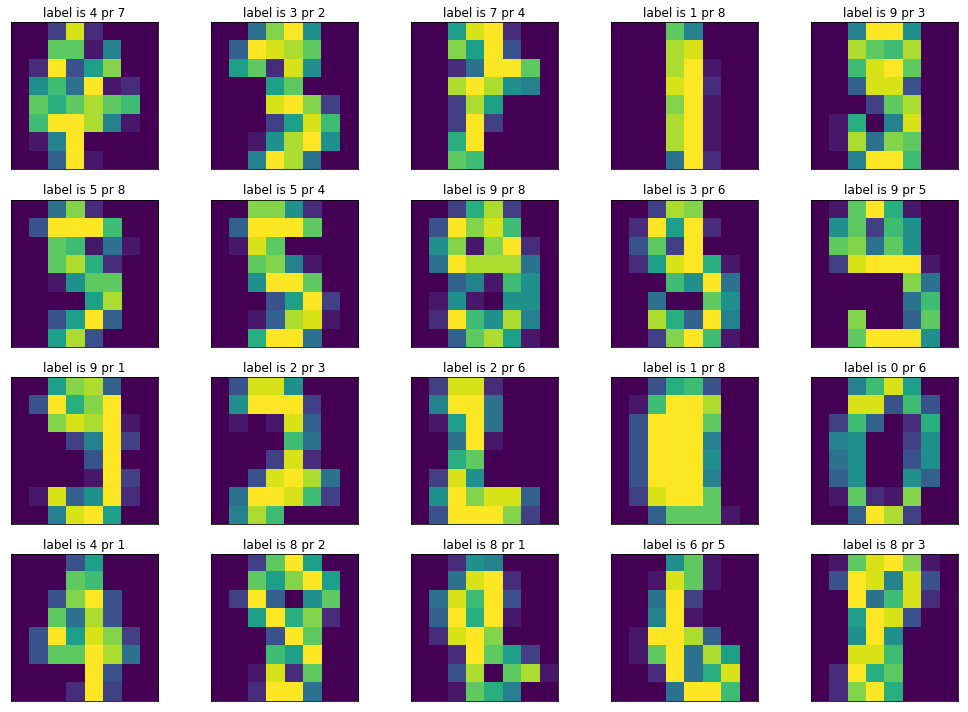

In [192]:
plot_invalid_labels(DecisionTreeClassifier(random_state=17))

In [194]:
d_tree2 = DecisionTreeClassifier(random_state=37)
bagging = BaggingClassifier(base_estimator=d_tree2, random_state=11, n_estimators=100)
fit_estimator(bagging)

0.92373845194412973

In [197]:
d_tree = DecisionTreeClassifier(random_state=37)
bagging = BaggingClassifier(base_estimator=d_tree, random_state=11, n_estimators=100, 
                            max_features=int(np.sqrt(X.shape[1])))
fit_estimator(bagging)

0.93724567203048781

In [199]:
d_tree = DecisionTreeClassifier(random_state=37, max_features=int(np.sqrt(X.shape[1])))
bagging = BaggingClassifier(base_estimator=d_tree, random_state=11, n_estimators=100)
fit_estimator(bagging)

0.95331794341937481

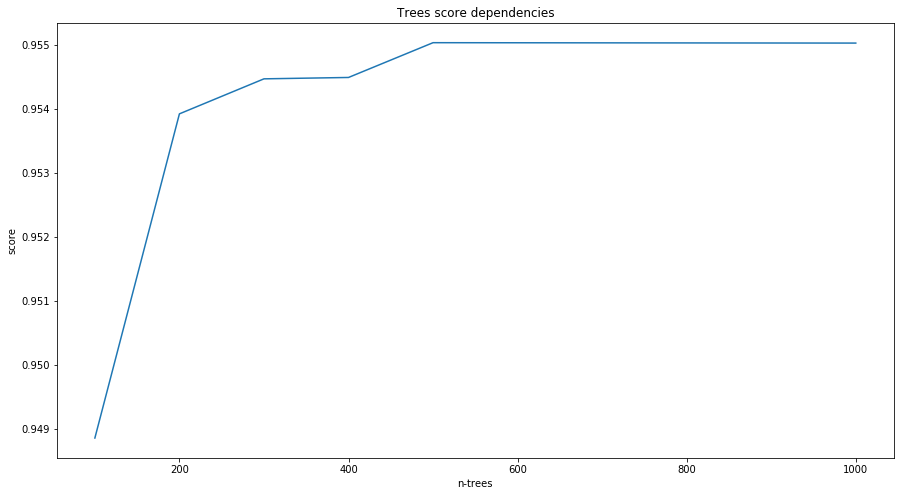

CPU times: user 1.3 s, sys: 438 ms, total: 1.74 s
Wall time: 45.6 s


In [212]:
%%time
def plot_rf_trees_score():
    trees = [100, 200, 300, 400, 500, 1000]
    results = []
    for tree in trees:
        rf = RandomForestClassifier(n_estimators=tree)
        results.append(fit_estimator(rf))
    plt.figure(figsize=(15, 8))
    plt.plot(trees, results)
    plt.xlabel("n-trees")
    plt.ylabel("score")
    plt.title("Trees score dependencies")
    plt.show()
plot_rf_trees_score()    

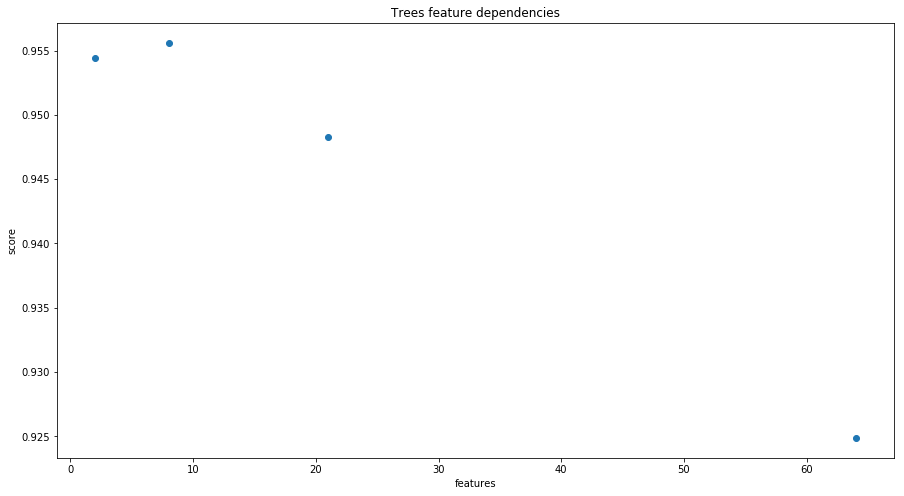

CPU times: user 1.06 s, sys: 322 ms, total: 1.38 s
Wall time: 53.3 s


In [213]:
%%time
def plot_rf_trees_max_features():
    d = X.shape[1]
    features = [2, int(np.sqrt(d)), int(d/3), d]
    results = []
    for f in features:
        rf = RandomForestClassifier(n_estimators=400, random_state=101, max_features=f)
        results.append(fit_estimator(rf))
    plt.figure(figsize=(15, 8))
    plt.plot(features, results, 'o')
    plt.xlabel("features")
    plt.ylabel("score")
    plt.title("Trees feature dependencies")
    plt.show()
plot_rf_trees_max_features() 

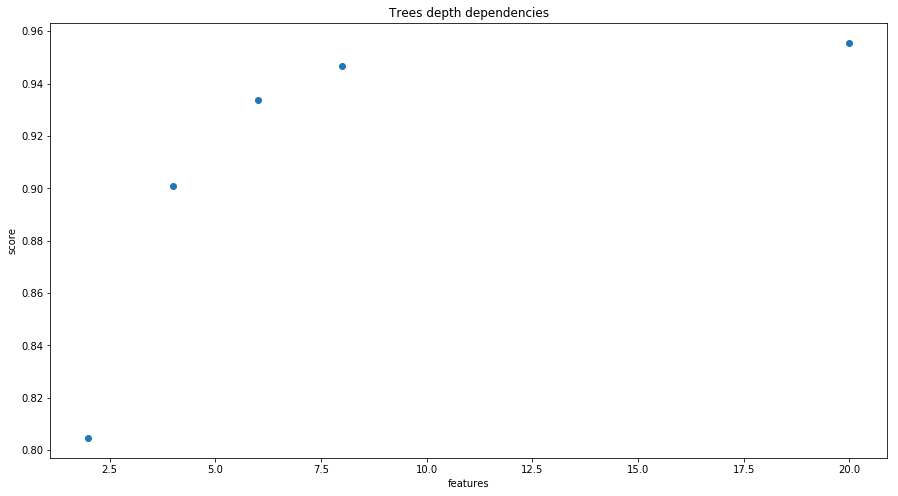

CPU times: user 1.12 s, sys: 365 ms, total: 1.48 s
Wall time: 28.3 s


In [214]:
%%time
def plot_rf_tree_depth():
    d = X.shape[1]
    depth = [2, 4, 6, 8, 20]
    results = []
    for d in depth:
        rf = RandomForestClassifier(n_estimators=400, random_state=101, max_depth=d)
        results.append(fit_estimator(rf))
    plt.figure(figsize=(15, 8))
    plt.plot(depth, results, 'o')
    plt.xlabel("features")
    plt.ylabel("score")
    plt.title("Trees depth dependencies")
    plt.show()
plot_rf_tree_depth() 

In [239]:
from sklearn.datasets import load_boston
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

In [220]:
boston = load_boston()
X = boston.data
Y = boston.target

In [222]:
X.shape, Y.shape, len(X)

((506, 13), (506,), 506)

In [287]:
def create_gb():
    base_algorithms_list = []
    coefficients_list = []

    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=51)

    def gbm_predict(X_loc):
        return [sum([coeff * algo.predict([x])[0] for algo, coeff in zip(base_algorithms_list, coefficients_list)])
                for x in X_loc]
    
    def get_grad():
        return [y - a for a, y in zip(gbm_predict(X_train), y_train) ]
    
    
    rg = DecisionTreeRegressor(random_state=42, max_depth=5)
    rg.fit(X_train, get_grad())
    base_algorithms_list.append(rg)
    coefficients_list.append(0.9)
    for i in np.arange(1, 50):
        rg = DecisionTreeRegressor(random_state=42, max_depth=5)
        rg.fit(X_train, get_grad())
        
        base_algorithms_list.append(rg)
        coefficients_list.append(0.9 / (1.0 + i))
    
    pred = gbm_predict(X_test)
    return np.sqrt(mean_squared_error(y_test, pred))
    
    
create_gb()    

5.3396087389433395

In [277]:
from xgboost import XGBRegressor

def test_with_xgb():
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=51)
    algo = XGBRegressor(n_estimators=100)
    algo.fit(X_train, y_train)
    pred = algo.predict(X_test)
    return np.sqrt(mean_squared_error(y_test, pred))
test_with_xgb()

3.4378376970273403

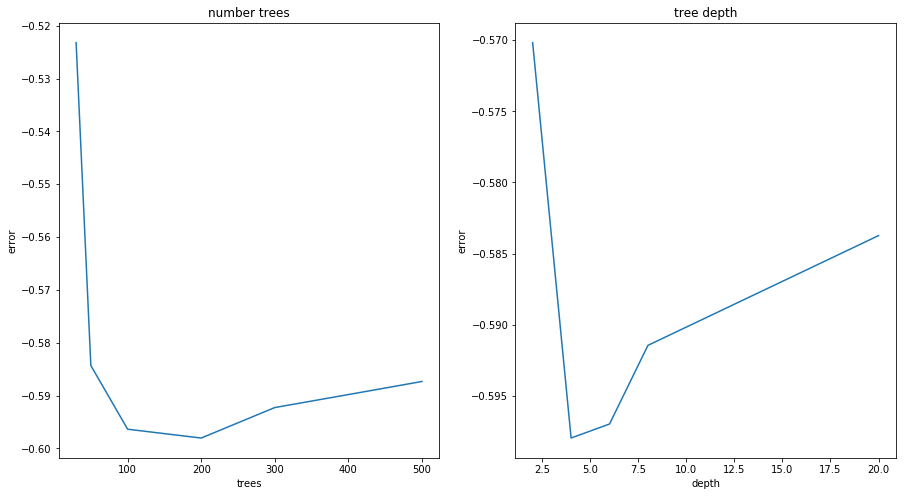

In [300]:
def test_xbg():
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=51)
    plt.figure(figsize=(15,8))
    
    trees = [30, 50, 100, 200, 300, 400, 500]
    errors = []
    for tree in trees:
        errors.append(
                -cross_val_score(XGBRegressor(n_estimators=tree), X, Y).mean()
        )
    plt.subplot(121)
    plt.plot(trees, errors)
    plt.xlabel("trees")
    plt.ylabel("error")
    plt.title("number trees")
    
    depth = [2, 4, 6, 8, 20]
    errors = []
    for d in depth:
        errors.append(
                -cross_val_score(XGBRegressor(max_depth=d), X, Y).mean()
        )
    plt.subplot(122)
    plt.plot(depth, errors)
    plt.xlabel("depth")
    plt.ylabel("error")
    plt.title("tree depth")    
    plt.show()
test_xbg()        
    
    

In [302]:
from sklearn.linear_model import LinearRegression

def compare_with_lr():
    lr = LinearRegression()
    error = cross_val_score(lr, X,Y).mean()
    return error

compare_with_lr()

/usr/local/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


-1.5787701857180345